In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error
from catboost import CatBoostRegressor
from sklearn.model_selection import TimeSeriesSplit

In [10]:
dataset=pd.read_csv('train.csv')

year             0
month            0
day              0
latitude         0
longitude        0
zon.winds    14570
mer.winds    14570
humidity     38794
air temp.     7838
s.s.temp.        0
dtype: int64

In [11]:
dataset['humidity'].interpolate(inplace=True)

year             0
month            0
day              0
latitude         0
longitude        0
zon.winds    14570
mer.winds    14570
humidity         0
air temp.     7838
s.s.temp.        0
dtype: int64

In [12]:
dataset['zon.winds'].fillna(np.random.normal(dataset['zon.winds'].mean(),dataset['zon.winds'].std()),inplace=True)
dataset['mer.winds'].fillna(np.random.normal(dataset['mer.winds'].mean(),dataset['mer.winds'].std()),inplace=True)

In [13]:
dataset['humidity']=dataset['humidity'].fillna(dataset['humidity'].mean(),)

In [14]:
dataset=dataset.dropna(subset=['air temp.'])

In [15]:
dataset.head()

,year,month,day,latitude,longitude,zon.winds,mer.winds,humidity,air temp.,s.s.temp.
0,1992,12,13,-4.99,156.0,4.8,-2.8,78.500000,28.98,30.06
1,1989,5,14,0.00,-110.1,-2.5,2.4,79.866667,24.95,25.23
2,1993,6,28,2.04,-110.2,-4.5,5.9,81.233333,25.78,27.84
3,1995,1,8,1.98,-140.0,-7.7,1.2,82.600000,26.47,26.86
4,1995,2,21,5.01,-170.0,-5.4,-6.6,75.200000,28.83,28.90


Mean Squared Error: 0.13947853004573496
R-squared: 0.9704686133251248
0.28326759672043383
Model Score (R²): 0.9704686133251248
        Actual  Predicted
78338    27.98  27.531274
78339    28.16  28.549408
78340    27.22  27.057513
78341    27.10  26.863137
78342    28.38  27.998110
...        ...        ...
104402   28.84  29.208240
104403   23.78  24.280445
104405   29.44  29.224833
104407   25.95  26.076544
104408   29.03  28.631599

[24142 rows x 2 columns]
Predicted Surface Temperature: 29.68144191917065


C:\Users\dell\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


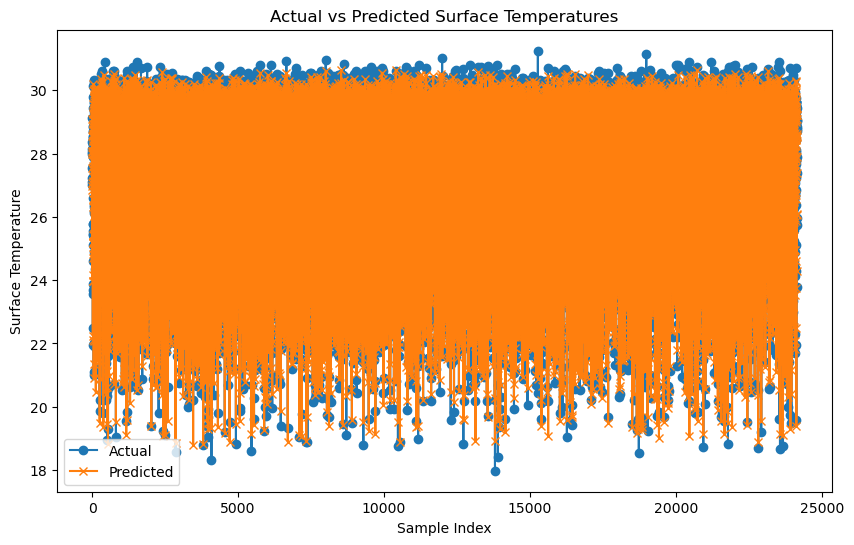

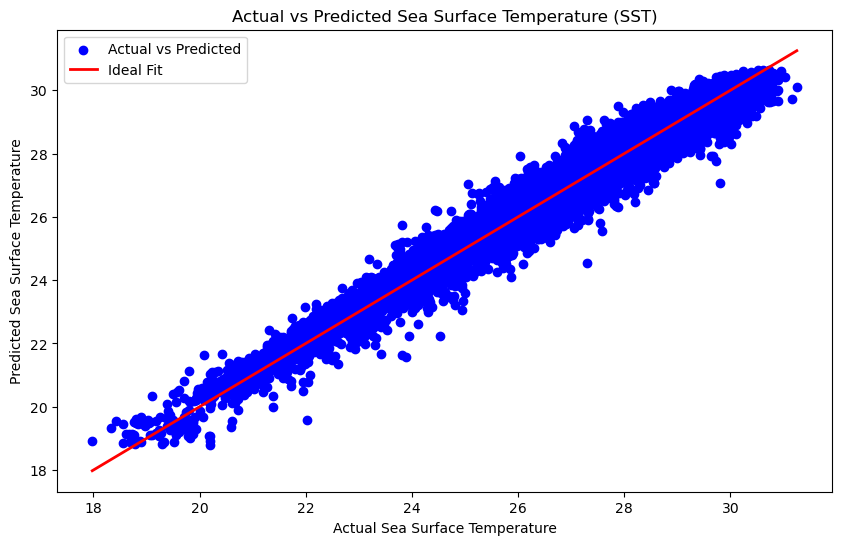

In [16]:
# Train-test split
X = dataset[['latitude', 'longitude', 'zon.winds', 'mer.winds', 'humidity', 'air temp.']]
y = dataset['s.s.temp.']

tss=TimeSeriesSplit(n_splits=3)
for train,test in tss.split(X):
    X_train,X_test=X.iloc[train,:],X.iloc[test,:]
    y_train,y_test=y.iloc[train],y.iloc[test]
    
# Feature scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Initialize the CatBoost model
catboost_model = CatBoostRegressor(iterations=1000, learning_rate=0.1, depth=6, random_seed=42, verbose=0)

# Train the model
catboost_model.fit(X_train, y_train)

# Predicting test results
y_pred = catboost_model.predict(X_test)

# Metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print metrics
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")
print(mean_absolute_error(y_test,y_pred))

# Model score (R²)
model_score = catboost_model.score(X_test, y_test)
print(f"Model Score (R²): {model_score}")

# Results dataframe
results_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
print(results_df)

# Predicting surface temperature for sample data
sample_data = [[-4.99, 156, 4.8, -2.8, 78.5, 28.98]]  
scaled_sample_data = scaler.transform(sample_data)
predicted_temp = catboost_model.predict(scaled_sample_data)
print(f"Predicted Surface Temperature: {predicted_temp[0]}")

# Plotting the actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual', marker='o')
plt.plot(y_pred, label='Predicted', marker='x')
plt.title('Actual vs Predicted Surface Temperatures')
plt.xlabel('Sample Index')
plt.ylabel('Surface Temperature')
plt.legend()
plt.show()

# Scatter plot of actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', label='Actual vs Predicted')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2, label='Ideal Fit')
plt.xlabel('Actual Sea Surface Temperature')
plt.ylabel('Predicted Sea Surface Temperature')
plt.title('Actual vs Predicted Sea Surface Temperature (SST)')
plt.legend()
plt.show()